# Imports

In [1]:
import glob

import numpy as np 
import pandas as pd

from scipy.spatial import ConvexHull

# scikit learn imports for classification functions
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

# Reading the dataset

From the readme for the xyz files, we know that:

Ground truth labels:
|File range|Label|
|:--|:--|
|    000 - 099: |building|
|    100 - 199: |car|
|    200 - 299: |fence|
|    300 - 399: |pole|
|    400 - 499: |tree|

In following cell: iterate through the files, and collect them in a dataframe

In [2]:
xyzPath = './scene_objects/data/*.xyz'
dataPathsList = glob.glob(xyzPath)

allPointsDF= pd.DataFrame(columns=['x','y','z', 'fileNo', 'groundLabel'])
# featureDF = pd.DataFrame(columns=['Label' , 'convHull', median] )

labelToGive = None
for path in dataPathsList:
    indx = int(path.split('\\')[-1][0:3])
    # if else to determine label
    if indx>=0 and indx<100:
        labelToGive = 'building' 
    elif indx>=100 and indx<200:
        labelToGive = 'car' 
    elif indx>=200 and indx<300:
        labelToGive = 'fence' 
    elif indx>=300 and indx<400:
        labelToGive = 'pole' 
    elif indx>=400 and indx<500:
        labelToGive = 'tree'       

    # using pandas to read dataset and make a dataFrame
    tempDF = pd.read_csv(path, delimiter=' ', header=None, dtype=np.float64, names=['x','y','z'])
    tempDF.loc[:,'fileNo'] = indx
    tempDF.loc[:,'groundLabel'] = labelToGive

    # merge with megaDFofPoints
    allPointsDF = pd.concat([allPointsDF, tempDF], sort=False, ignore_index=True)

allPointsDF.head()

,x,y,z,fileNo,groundLabel
0,20.070000,499.959991,17.450001,0,building
1,20.370001,499.160004,17.290001,0,building
2,18.860001,499.559998,18.129999,0,building
3,18.120001,499.709991,18.540001,0,building
4,17.360001,499.950012,19.000000,0,building


# Features engineering

normalize the feature df <br/>
[from stackoverflow we see](https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame), that we can just use pandas for a standard scaling, or else, a [standard scaler from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) can also be applied </br>

from [answer here](https://stats.stackexchange.com/questions/417339/data-standardization-vs-normalization-for-clustering-analysis), we see that standard scaler is used for k means , so we are going with that

In [3]:
def label_determiner(indx):
    labelToGive=None
    if indx>=0 and indx<100:
        labelToGive = 'building' 
    elif indx>=100 and indx<200:
        labelToGive = 'car' 
    elif indx>=200 and indx<300:
        labelToGive = 'fence' 
    elif indx>=300 and indx<400:
        labelToGive = 'pole' 
    elif indx>=400 and indx<500:
        labelToGive = 'tree' 
    return labelToGive

In [4]:
# create feature dataset in DataFrame
featureDF = allPointsDF.groupby('fileNo').var()
featureDF.rename(columns={'x':'varX','y':'varY','z':'varZ'}, inplace=True)
#featureDF.loc[:,'median_Z'] = allPointsDF.groupby('fileNo').z.median()
featureDF.loc[:,'mean_Z'] = allPointsDF.groupby('fileNo').z.mean()

# range of x,y,z
featureDF.loc[:,'range_X'] = allPointsDF.groupby('fileNo').x.max() - allPointsDF.groupby('fileNo').x.min()
featureDF.loc[:,'range_Y'] = allPointsDF.groupby('fileNo').y.max() - allPointsDF.groupby('fileNo').y.min()
featureDF.loc[:,'range_Z'] = allPointsDF.groupby('fileNo').z.max() - allPointsDF.groupby('fileNo').z.min()

# volume
featureDF.loc[:,'volume'] = allPointsDF.set_index('fileNo').loc[:,'x':'z'].groupby('fileNo').apply(ConvexHull).apply(lambda x: x.volume)

# ratio
featureDF.loc[:,'ratio'] = featureDF.loc[:,'range_Z']/ featureDF.loc[:,'range_X']

# point density
featureDF.loc[:,'footprintDensity'] =  allPointsDF.groupby('fileNo').count().x / (featureDF.range_X * featureDF.range_Y)
featureDF.loc[:,'volumeDensity'] =  allPointsDF.groupby('fileNo').count().x / featureDF.volume

# label
featureDF.loc[:,'label'] = featureDF.reset_index().fileNo.apply(label_determiner)

In [5]:
# delete varX, varY, varZ
featureDF = featureDF.drop(columns = ['varX', 'varY', 'varZ','range_X','range_Y'], axis = 1)
featureDF = featureDF.drop(columns = ['mean_Z', 'volumeDensity'], axis = 1)
featureDF

,range_Z,volume,ratio,footprintDensity,label
fileNo,,,,,
0,5.02,104.189009,0.479008,37.121449,building
1,3.60,137.366395,0.341556,32.078876,building
2,7.49,1247.880682,0.439554,32.711848,building
3,7.07,1326.712538,0.334121,29.001490,building
4,5.21,1100.901866,0.220950,23.277809,building
...,...,...,...,...,...
495,7.19,138.917876,1.031566,67.520725,tree
496,12.44,645.231457,1.169171,62.822416,tree
497,6.84,84.578072,1.295455,31.994384,tree


In [6]:
noLabelFeatureDF = featureDF.iloc[:,:-1].copy() # delete label column

# standardize DF
standardFeatureDF = (noLabelFeatureDF - noLabelFeatureDF.mean() ) / noLabelFeatureDF.std()
standardFeatureDF = standardFeatureDF.join(other=featureDF.label , on='fileNo') # join labels to the DF

# normalize df using min max scaling
minMaxFeatureDF = (noLabelFeatureDF- noLabelFeatureDF.min()) / (noLabelFeatureDF.max() - noLabelFeatureDF.min())
minMaxFeatureDF = minMaxFeatureDF.join(other=featureDF.label , on='fileNo') # join labels to the DF

minMaxFeatureDF.head()

,range_Z,volume,ratio,footprintDensity,label
fileNo,,,,,
0,0.199121,0.004124,0.027853,0.382691,building
1,0.136703,0.005448,0.019509,0.329856,building
2,0.307692,0.049745,0.025458,0.336488,building
3,0.289231,0.052889,0.019058,0.297612,building
4,0.207473,0.043882,0.012187,0.237640,building


### Correlation matrix
Summarize data with a table that showscorrelation coefficients between variables

In [7]:
minMaxFeatureDF.corr()

,range_Z,volume,ratio,footprintDensity
range_Z,1.000000,0.118549,0.488571,0.314815
volume,0.118549,1.000000,-0.116409,0.014749
ratio,0.488571,-0.116409,1.000000,0.280281
footprintDensity,0.314815,0.014749,0.280281,1.000000


### Plotting to see resemblamces and clusters

In [8]:
# 3d scatterplot using matplotlib

def scatter3d(df, feature1, feature2, feature3=0):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111, projection='3d')

    labelList = ["building", "car", "fence", "pole", "tree"]
    colorList = ["blue", "orange", "green", "#D12B60", "purple"]

    for i in range(0,5):
        tempDF = featureDF.loc[featureDF["label"] == labelList[i]]
        x,y,z = np.array(tempDF[feature1]), np.array(tempDF[feature2]), np.array(tempDF[feature3])
        ax.scatter(x,y,z,s=40,color = colorList[i], label = labelList[i] )
    
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel(feature3)
    ax.legend()
    plt.show()

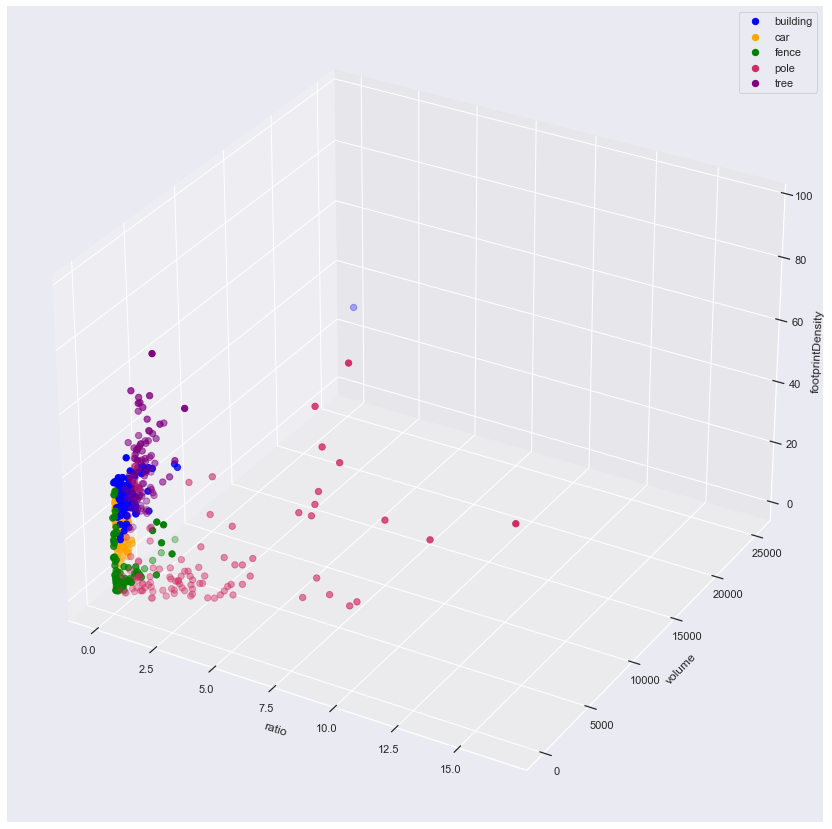

In [9]:
scatter3d(standardFeatureDF,"ratio","volume","footprintDensity")

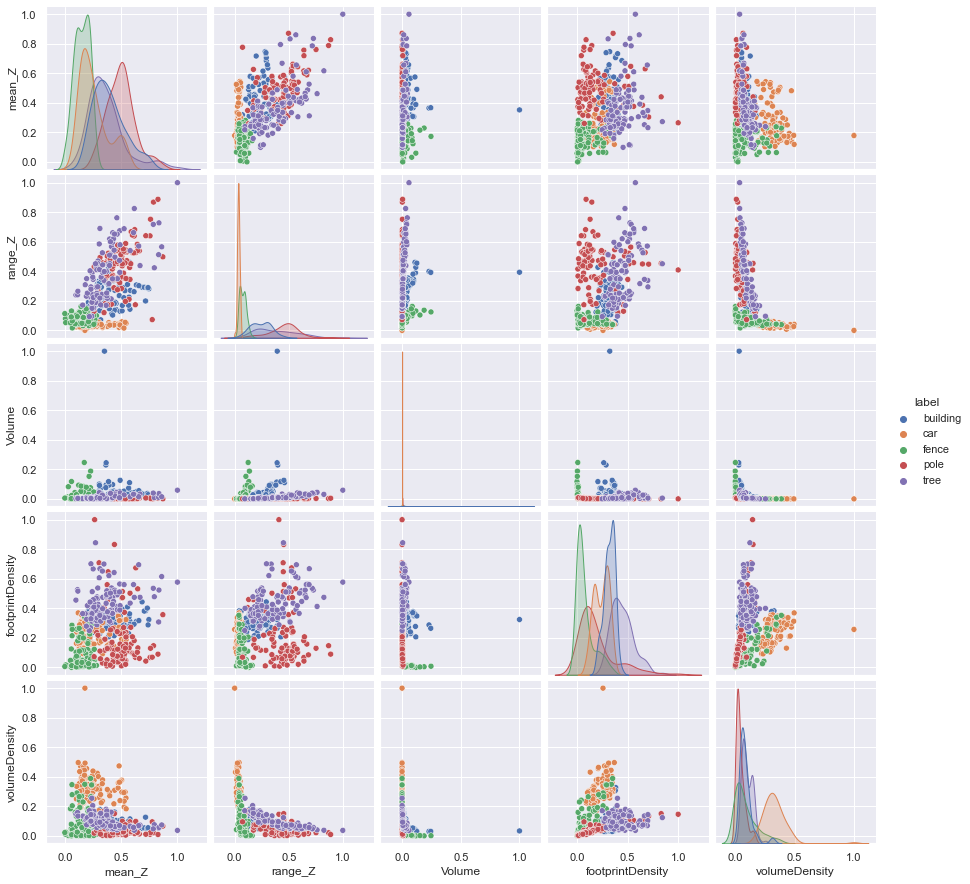

In [70]:
sns.pairplot(data=minMaxFeatureDF, hue="label")

# Classification
## Split the dataset

In [10]:
def testTrainSplitter(DataFrame, testSize=0.3, randomState=45):
    """
    Summary: takes a dataframe in the format of the one defined in section making features, and returns test set train set X,y.
    ===================
    Arguments:
        DataFrame (pd.DataFrame):
        testSize (float):
        randomState (int):
    Returns:
    """
    X = DataFrame.drop('label', axis=1)
    y = DataFrame.loc[:,'label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=randomState , shuffle=True)
    return (X_train, X_test, y_train, y_test)


In [11]:
# split dataset
minMax_X_train, minMax_X_test, minMax_y_train, minMax_y_test = testTrainSplitter(minMaxFeatureDF, 0.2)

## Implement SVM and random forest

In [12]:
# implement SVM
svmClassifier = SVC(decision_function_shape='ovo', kernel='linear') # function from sklearn
svmClassifier.fit(minMax_X_train, minMax_y_train)
svmPredList = svmClassifier.predict(minMax_X_test)

# implement random forest
rfClassifier = RandomForestClassifier(n_estimators = 50, max_depth=2, random_state=0)
rfClassifier.fit(minMax_X_train, minMax_y_train)
rfPredList = rfClassifier.predict(minMax_X_test)

# Evaluation
## Accuracy
In this case, the value of overall accuracy is equial to that of mean per-class accuracy.

In [13]:
svmAccuracy = accuracy_score(minMax_y_test, svmPredList)
rfAccuracy = accuracy_score(minMax_y_test, rfPredList)

svmAccuracy, rfAccuracy

(0.79, 0.85)

## Learning curve

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
# https://www.projectpro.io/recipes/plot-learning-curve-in-python

def learningCurve(estimator,X,y):
    """
    Determines cross-validated training and test scores for different training set sizes.
    Parameters:
        estimator: An object of that type which is cloned for each validation.
        X: array-like of shape (n_samples, n_features). Training vector, where n_samples is the number of samples and n_features is the number of features.
        y: array-like of shape (n_samples,) or (n_samples, n_outputs).Target relative to X for classification or regression; None for unsupervised learning.
    Return:
        No return. Just plot the curve.
    """
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

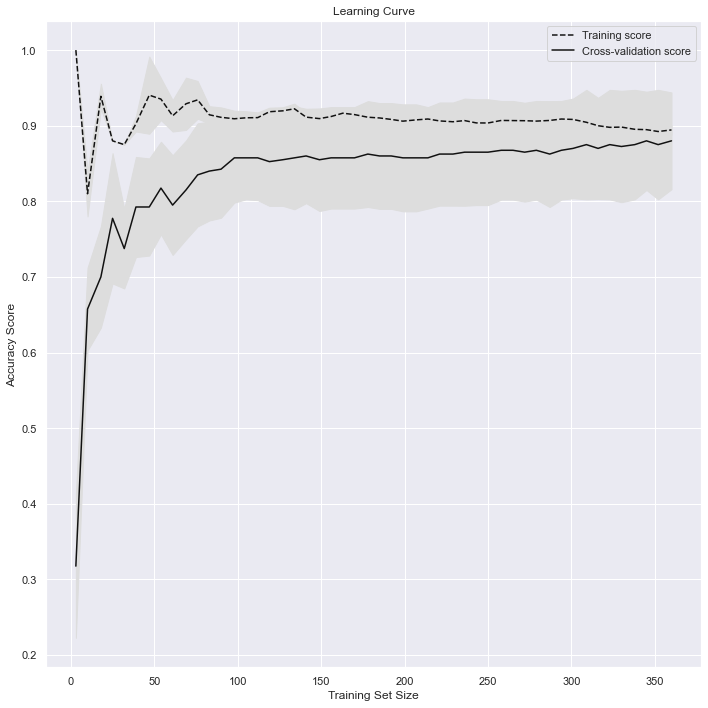

In [15]:
# The learning curve of SVM
learningCurve(SVC(),minMax_X_train, minMax_y_train)

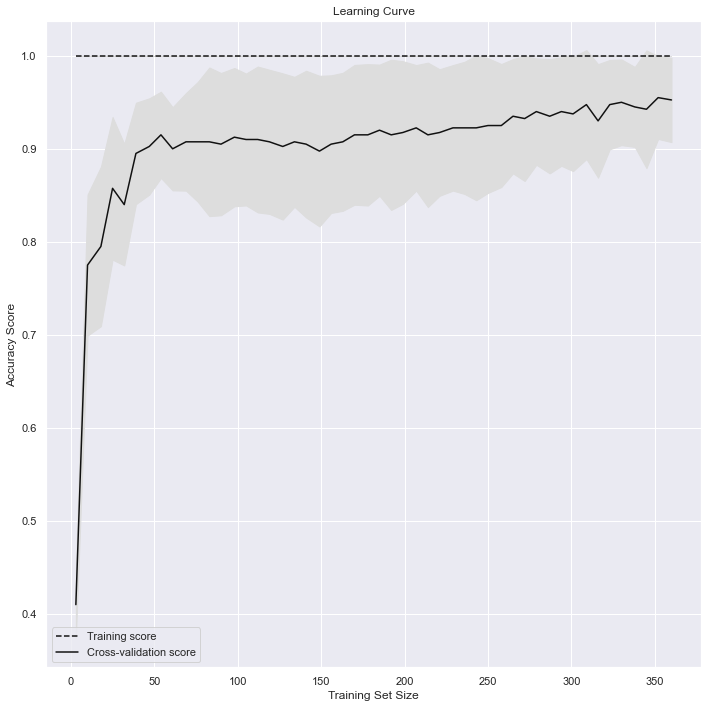

In [16]:
# The learning curve of random forest
learningCurve(RandomForestClassifier(), minMax_X_train, minMax_y_train)

## Confusion matrix

In [17]:
# The confusion matrix of SVM
confusion_matrix(minMax_y_test, svmPredList)

array([[15,  4,  0,  0,  0],
       [ 0, 17,  0,  0,  0],
       [ 0,  7, 19,  0,  0],
       [ 1,  1,  0, 17,  0],
       [ 8,  0,  0,  0, 11]], dtype=int64)

In [18]:
# The confusion matrix of random forest
confusion_matrix(minMax_y_test, rfPredList)

array([[15,  0,  4,  0,  0],
       [ 0, 17,  0,  0,  0],
       [ 1,  5, 19,  1,  0],
       [ 0,  1,  0, 15,  3],
       [ 0,  0,  0,  0, 19]], dtype=int64)